# MNIST with sklearn

We'll run through MNIST using the sklearn library. Data for this notebook was pulled from:
https://www.kaggle.com/c/digit-recognizer

which at the time contained a set if files encompassing a subset of the MNIST dataset, divided into train/test/submission sets.

In [92]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import sys
import time
import random
import tarfile
from IPython.display import display, Image

from scipy import ndimage
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

datadir=".\\data\\digits_recognizer\\"
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

##Function definitions

In [88]:
def loadData(filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    try:
        data = pd.read_csv(filename, parse_dates=True)
        #data.drop(['Region', 'Channel'], axis = 1, inplace = True)
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data
def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

def dispImage(image):
        plt.imshow(image, cmap='binary')
        plt.show()
    
def runPredict(clf,Data, display=True):
    index=random.randrange(len(Data))
    y_pred = clf.predict(Data[index].reshape(1, -1))[0]
    if display==True:
        dispImage(np.reshape(Data[index],(28,28)))
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf="", usePCA=False):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

 
        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=1000,C=1e-5)
            
        if usePCA ==True:
            pca=decomposition.PCA(n_components = 14*14)
            clf=Pipeline(steps=[('pca', pca), ('classifier', clf )]) # set up the clf as a pipeline ])
        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

## Load the Training data
We'll load the training data and take a look at a row, verify features, etc. We'll also display a data point as an image and verify it matches the label

Dataset has 42000 samples with 785 features each.
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0         0  

[1 rows x 785 columns]
('size of each entry', 784)
('for index', 1662, 'label is:', 1)


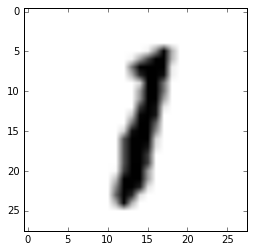

In [67]:
#Load up the train data
trainData=loadData(datadir+"train.csv")
print (trainData.head(1))
y = trainData["label"]
x = trainData.drop("label", axis=1)
#print (y.head(2))
#print (x.head(2))

#print (x.values[5])
print ("size of each entry",len(x.values[5]))

index=random.randrange(len(x))
print("for index",index,"label is:",y.values[index])
dispImage(np.reshape(x.values[index],(28,28)))

## Split the data for train/test, and run training data of various size through the classifier
We use train_test_split, from the sklearn.cross_validation to split the data into a training and validation group. Then we feed this data in various test sizes to a classifier and evaluate the scores. 
Finally, we run a prediction on a random value from the validation set, and visually ensure that it is predicted correctly!

In [121]:
#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x.values, y.values, test_size=0.25, random_state=42)

dataSize=X_train.shape[0]
print ("size of train data",dataSize, )
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

test_sizes=[63,630,6300,31500]
#test_sizes=[50,500,5001]
print ("run tests of size",test_sizes)


('size of train data', 31500L)
('run tests of size', [63, 630, 6300, 31500])


Logistic:
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 12.833')
('F1 score for training set: 0.975714285714,', 'Prediction time (secs): 0.022')
('F1 score for test set: 0.905396825397,', 'Prediction time (secs): 0.024')
('\n', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))
Test F1:[0.90539682539682542]


'Train F1:[0.97571428571428576]'

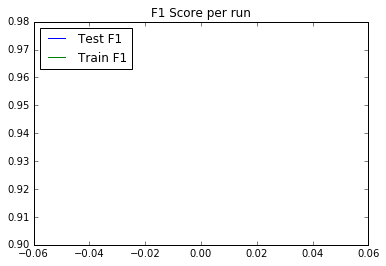

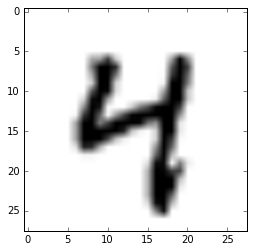

('Validation Prediction is:', 4)


In [115]:
print ("Logistic:")
clf=runTests(test_sizes, X_train,y_train,X_test,y_test)
print("Validation Prediction is:",runPredict(clf,X_test))

AdaBoost:
------------------------------------------
('Training set size: 63,', 'Train time (secs): 0.226')
('F1 score for training set: 0.222222222222,', 'Prediction time (secs): 0.005')
('F1 score for test set: 0.111111111111,', 'Prediction time (secs): 0.006')
------------------------------------------
('Training set size: 630,', 'Train time (secs): 0.549')
('F1 score for training set: 0.404761904762,', 'Prediction time (secs): 0.025')
('F1 score for test set: 0.398412698413,', 'Prediction time (secs): 0.024')
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 6.206')
('F1 score for training set: 0.689206349206,', 'Prediction time (secs): 0.282')
('F1 score for test set: 0.683650793651,', 'Prediction time (secs): 0.252')
------------------------------------------
('Training set size: 31500,', 'Train time (secs): 34.460')
('F1 score for training set: 0.733238095238,', 'Prediction time (secs): 1.390')
('F1 score for test set: 0.728380952381,', 

'Train F1:[0.22222222222222221, 0.40476190476190477, 0.68920634920634916, 0.73323809523809513]'

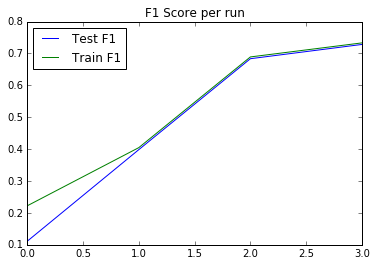

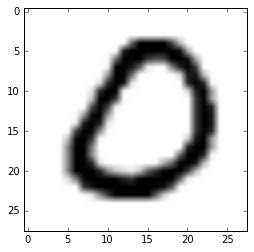

('Validation Prediction is:', 0)


In [84]:
print ("AdaBoost:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,ensemble.AdaBoostClassifier())
print("Validation Prediction is:",runPredict(clf,X_test))

AdaBoost:
------------------------------------------
('Training set size: 1000,', 'Train time (secs): 1.527')
('F1 score for training set: 0.411,', 'Prediction time (secs): 0.045')
('F1 score for test set: 0.399,', 'Prediction time (secs): 0.036')
------------------------------------------
('Training set size: 3000,', 'Train time (secs): 4.244')
('F1 score for training set: 0.518,', 'Prediction time (secs): 0.116')
('F1 score for test set: 0.478333333333,', 'Prediction time (secs): 0.122')
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 9.073')
('F1 score for training set: 0.671587301587,', 'Prediction time (secs): 0.263')
('F1 score for test set: 0.663968253968,', 'Prediction time (secs): 0.263')
------------------------------------------
('Training set size: 31500,', 'Train time (secs): 50.168')
('F1 score for training set: 0.707968253968,', 'Prediction time (secs): 1.579')
('F1 score for test set: 0.704380952381,', 'Prediction time (secs):

'Train F1:[0.41099999999999998, 0.51800000000000002, 0.67158730158730162, 0.70796825396825391]'

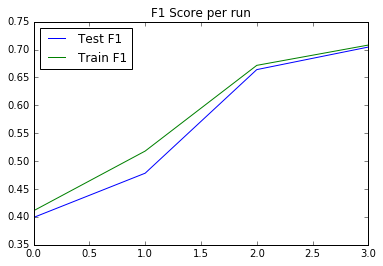

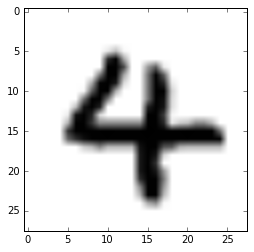

('Validation Prediction is:', 4)


In [86]:
test_sizes=[1000,3000,6300,31500]
print ("AdaBoost:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,ensemble.AdaBoostClassifier(), usePCA=True)
print("Validation Prediction is:",runPredict(clf,X_test))

LinearSVC:
------------------------------------------
('Training set size: 63,', 'Train time (secs): 0.407')
('F1 score for training set: 1.0,', 'Prediction time (secs): 0.001')
('F1 score for test set: 0.809523809524,', 'Prediction time (secs): 0.001')
------------------------------------------
('Training set size: 630,', 'Train time (secs): 1.148')
('F1 score for training set: 1.0,', 'Prediction time (secs): 0.002')
('F1 score for test set: 0.809523809524,', 'Prediction time (secs): 0.002')
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 20.620')
('F1 score for training set: 0.978253968254,', 'Prediction time (secs): 0.021')
('F1 score for test set: 0.850634920635,', 'Prediction time (secs): 0.020')
------------------------------------------
('Training set size: 31500,', 'Train time (secs): 68.987')
('F1 score for training set: 0.884,', 'Prediction time (secs): 0.121')
('F1 score for test set: 0.857238095238,', 'Prediction time (secs): 0.03

'Train F1:[1.0, 1.0, 0.97825396825396826, 0.88400000000000001]'

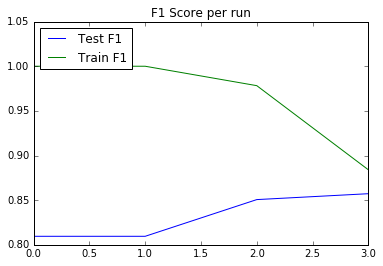

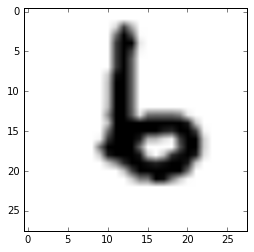

('Validation Prediction is:', 6)


In [85]:
print ("LinearSVC:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,LinearSVC(class_weight="balanced"))
print("Validation Prediction is:",runPredict(clf,X_test))

KNeighborsClassifier:
------------------------------------------
('Training set size: 1000,', 'Train time (secs): 0.121')
('F1 score for training set: 0.918,', 'Prediction time (secs): 0.874')
('F1 score for test set: 0.874,', 'Prediction time (secs): 0.743')
------------------------------------------
('Training set size: 3000,', 'Train time (secs): 0.157')
('F1 score for training set: 0.946666666667,', 'Prediction time (secs): 4.552')
('F1 score for test set: 0.922666666667,', 'Prediction time (secs): 4.447')
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 0.455')
('F1 score for training set: 0.957142857143,', 'Prediction time (secs): 18.997')
('F1 score for test set: 0.942380952381,', 'Prediction time (secs): 19.888')
------------------------------------------
('Training set size: 31500,', 'Train time (secs): 8.697')
('F1 score for training set: 0.977047619048,', 'Prediction time (secs): 640.837')
('F1 score for test set: 0.966666666667,', 

'Train F1:[0.91800000000000004, 0.94666666666666666, 0.95714285714285718, 0.97704761904761905]'

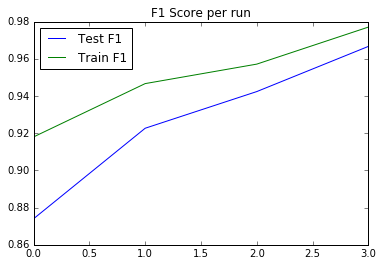

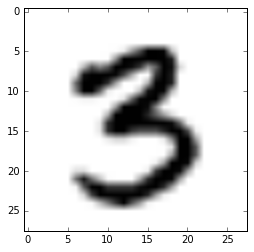

('Validation Prediction is:', 3)


In [87]:
print ("KNeighborsClassifier:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,KNeighborsClassifier(n_jobs =-1))
print("Validation Prediction is:",runPredict(clf,X_test))

## GridSearch!

['warm_start', 'C', 'n_jobs', 'verbose', 'intercept_scaling', 'fit_intercept', 'max_iter', 'penalty', 'multi_class', 'random_state', 'dual', 'tol', 'solver', 'class_weight']
post-Gridsearch:
------------------------------------------
('Training set size: 63,', 'Train time (secs): 0.264')
('F1 score for training set: 1.0,', 'Prediction time (secs): 0.000')
('F1 score for test set: 0.793650793651,', 'Prediction time (secs): 0.000')
------------------------------------------
('Training set size: 630,', 'Train time (secs): 0.424')
('F1 score for training set: 0.95873015873,', 'Prediction time (secs): 0.003')
('F1 score for test set: 0.853968253968,', 'Prediction time (secs): 0.003')
------------------------------------------
('Training set size: 6300,', 'Train time (secs): 6.031')
('F1 score for training set: 0.933968253968,', 'Prediction time (secs): 0.025')
('F1 score for test set: 0.904444444444,', 'Prediction time (secs): 0.023')
------------------------------------------
('Training se

'Train F1:[1.0, 0.95873015873015877, 0.933968253968254, 0.93085714285714283]'

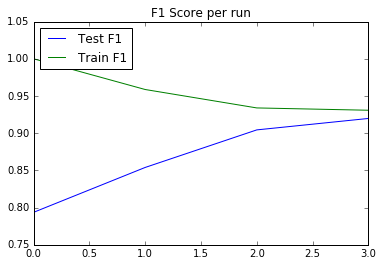

LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


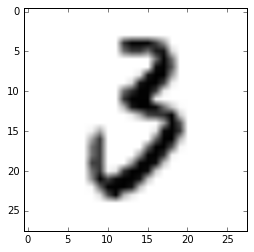

('Validation Prediction is:', 3)


In [122]:
   #search the param_grid for best params based on the f1 score
#test_sizes=[6300]

#print (clf.get_params().keys())
grid=dict(C=[1,5,1e-04,1e-05,1e-6,1e-9])

grid_search = GridSearchCV(clf, param_grid= grid, n_jobs= 4, scoring=make_scorer(f1_score))
grid_search.fit(X_train,y_train)

print ("post-Gridsearch:")
clf = runTests(test_sizes, X_train,y_train,X_test,y_test,grid_search.best_estimator_)
print (clf)
print("Validation Prediction is:",runPredict(clf,X_test))


## Test data, 
Now, we load the test data and make sure that it also can be used to make a prediction. the output should be correctly predicted or at least reasonably close!

Test Data:
Dataset has 28000 samples with 784 features each.


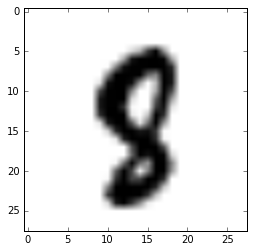

('Test Set Prediction is:', 8)


In [103]:
#loadup the  test data
print ("Test Data:")
testData=loadData(datadir+"test.csv") # no need to load this yet!print (testData)

#testData = np.array(testData).reshape((len(testData), -1))

print("Test Set Prediction is:",runPredict(clf,testData.values))

## Prep submission 
make a prediction for each test data point, and store. As we proceed throught the data, we check in to make sure that everything still is being predicted correctly!

('run:', 0, 'entry#:', 1, 'predicted:', 2)


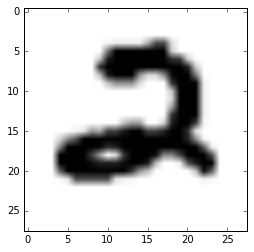

('run:', 5000, 'entry#:', 5001, 'predicted:', 1)


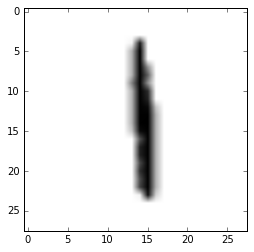

('run:', 10000, 'entry#:', 10001, 'predicted:', 0)


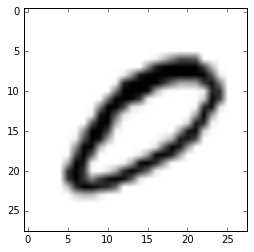

('run:', 15000, 'entry#:', 15001, 'predicted:', 5)


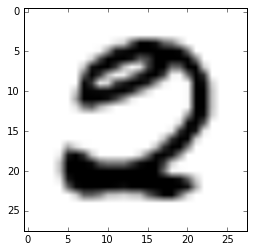

('run:', 20000, 'entry#:', 20001, 'predicted:', 7)


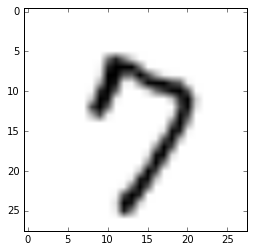

('run:', 25000, 'entry#:', 25001, 'predicted:', 2)


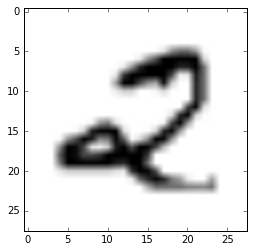

('size of submission', 28000)


In [104]:

submission =[]
for index in range(len(testData.values)):
    submission.append((index+1,clf.predict(testData.values[index].reshape(1, -1))[0]))
    if index%5000 == 0:
        print("run:",index,"entry#:",submission[index][0], "predicted:",submission[index][1])
        dispImage(np.reshape(testData.values[index],(28,28)))
        
print ("size of submission",len(submission))



## submission

write the data to a csv for submission!

In [ ]:
#Write our the data for submission
verify=writeData(pd.DataFrame(submission,columns=["ImageId","Label"]),'digitrecognizer-submission.csv')
print(verify)

## Conclusions...

regular statistical machine learning methods, via sklearn may be used to make a very successful prediction, but may not be up to the current state of the art. Deep learning methods, particularly a convolutional neural net, such as leCun or the inception net may perform better 

###EOF